In [1]:
from sklearn.ensemble import BaggingClassifier
import numpy as np

# Custom implementation of PART (partial decision tree)
import numpy as np

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature  # Feature index to split on
        self.threshold = threshold  # Threshold for binary split
        self.left = left  # Left subtree
        self.right = right  # Right subtree
        self.value = value  # Predicted value for leaf nodes

class PART:
    def __init__(self, max_depth=None, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf

    def fit(self, X, y):
        self.n_features_ = X.shape[1]
        self.tree_ = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._predict(inputs, self.tree_) for inputs in X])

    def _grow_tree(self, X, y, depth=0):
        # Stopping criteria
        if (self.max_depth is not None and depth >= self.max_depth) or len(np.unique(y)) == 1 or len(y) < self.min_samples_leaf:
            return Node(value=self._most_common_label(y))

        # Find the best split
        best_feature, best_threshold = self._find_best_split(X, y)

        if best_feature is None:
            return Node(value=self._most_common_label(y))

        # Split the data
        left_indices = X[:, best_feature] < best_threshold
        right_indices = ~left_indices

        left_subtree = self._grow_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._grow_tree(X[right_indices], y[right_indices], depth + 1)

        return Node(feature=best_feature, threshold=best_threshold, left=left_subtree, right=right_subtree)

    def _find_best_split(self, X, y):
        best_gini = float('inf')
        best_feature = None
        best_threshold = None

        for feature in range(self.n_features_):
            thresholds = np.unique(X[:, feature])

            for threshold in thresholds:
                left_indices = X[:, feature] < threshold
                gini = self._gini_impurity(y[left_indices], y[~left_indices])

                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _gini_impurity(self, left_labels, right_labels):
        p_left = len(left_labels) / (len(left_labels) + len(right_labels))
        p_right = len(right_labels) / (len(left_labels) + len(right_labels))

        gini_left = 1 - sum([(np.sum(left_labels == c) / len(left_labels)) ** 2 for c in np.unique(left_labels)])
        gini_right = 1 - sum([(np.sum(right_labels == c) / len(right_labels)) ** 2 for c in np.unique(right_labels)])

        gini = p_left * gini_left + p_right * gini_right
        return gini

    def _most_common_label(self, y):
        return np.bincount(y).argmax()

    def _predict(self, inputs, tree):
        if tree.value is not None:
            return tree.value

        if inputs[tree.feature] < tree.threshold:
            return self._predict(inputs, tree.left)
        else:
            return self._predict(inputs, tree.right)

    def get_params(self, deep=True):
        return {'max_depth': self.max_depth, 'min_samples_leaf': self.min_samples_leaf}

    def set_params(self, **params):
        if 'max_depth' in params:
            self.max_depth = params['max_depth']
        if 'min_samples_leaf' in params:
            self.min_samples_leaf = params['min_samples_leaf']
        return self


In [2]:
import pandas as pd
# data = pd.read_csv('/content/final-crop.csv')
data = pd.read_csv('Crop_recommendation.csv')


In [3]:

# Perform one-hot encoding for categorical features
# data_encoded = pd.get_dummies(data.drop(columns=['Crop']))
data_encoded = pd.get_dummies(data.drop(columns=['label']))


# Define features (X) and target variable (y)
X = data_encoded
# y = data['Crop']
y = data['label']


In [4]:
data_encoded.nunique()

N               137
P               117
K                73
temperature    2200
humidity       2200
ph             2200
rainfall       2200
dtype: int64

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:

# Define custom PART implementation
part = PART()

In [8]:
# Create BaggingClassifier ensemble with custom PART as base estimator
bagging_classifier = BaggingClassifier(base_estimator=part, n_estimators=10, random_state=42)


In [9]:

# Fit the BaggingClassifier on the training data
bagging_classifier.fit(X_train, y_train)

c:\Users\satwi\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingClassifier(base_estimator=<__main__.PART object at 0x000002537C3BA550>,
                  random_state=42)

In [10]:
X_test.iloc[373]

N              96.000000
P              86.000000
K              51.000000
temperature    29.908885
humidity       76.987408
ph              6.257370
rainfall       91.999647
Name: 1091, dtype: float64

In [11]:
y_test

1451     muskmelon
1334    watermelon
1761        papaya
1735        papaya
1576         apple
           ...    
59            rice
71            rice
1908        cotton
1958        cotton
482     pigeonpeas
Name: label, Length: 440, dtype: object

In [12]:
X_test.iloc[373]
y_test.iloc[373]

'banana'

In [13]:
# Make single prediction
single_prediction = bagging_classifier.predict([X_test.iloc[0]])

print("Prediction:", single_prediction)

Prediction: ['muskmelon']


c:\Users\satwi\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


In [14]:
# Make predictions
predictions = bagging_classifier.predict(X_test)

print("Predictions:", predictions)

Predictions: ['muskmelon' 'watermelon' 'papaya' 'papaya' 'apple' 'mango' 'apple'
 'mothbeans' 'mungbean' 'lentil' 'blackgram' 'coconut' 'pomegranate'
 'jute' 'coconut' 'pomegranate' 'apple' 'maize' 'papaya' 'muskmelon'
 'coffee' 'papaya' 'orange' 'papaya' 'chickpea' 'jute' 'mungbean' 'orange'
 'pigeonpeas' 'rice' 'pomegranate' 'mothbeans' 'jute' 'lentil' 'jute'
 'blackgram' 'jute' 'chickpea' 'chickpea' 'kidneybeans' 'papaya' 'mango'
 'blackgram' 'maize' 'mungbean' 'maize' 'pigeonpeas' 'coconut' 'muskmelon'
 'maize' 'blackgram' 'coffee' 'grapes' 'mungbean' 'coffee' 'kidneybeans'
 'cotton' 'apple' 'banana' 'blackgram' 'watermelon' 'coconut' 'lentil'
 'orange' 'papaya' 'blackgram' 'orange' 'rice' 'muskmelon' 'pigeonpeas'
 'muskmelon' 'coconut' 'jute' 'banana' 'blackgram' 'papaya' 'banana'
 'cotton' 'watermelon' 'orange' 'coffee' 'chickpea' 'rice' 'mothbeans'
 'orange' 'mango' 'coffee' 'mothbeans' 'blackgram' 'pomegranate' 'maize'
 'mothbeans' 'cotton' 'papaya' 'pigeonpeas' 'mothbeans' 'ki

In [15]:
# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy*100)

Accuracy: 98.4090909090909


In [16]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 21  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0 23  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate heatmap

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


ModuleNotFoundError: No module named 'seaborn'

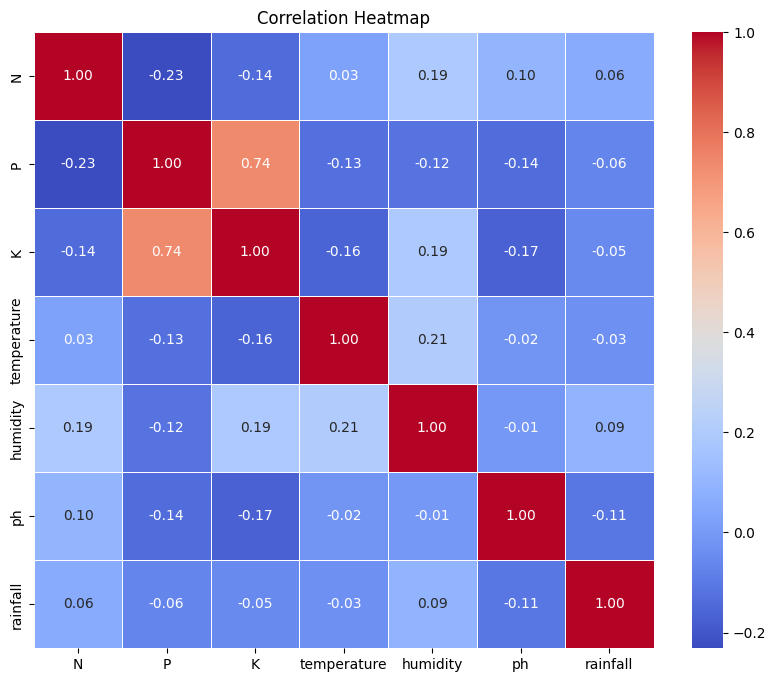

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Drop the 'label' column
# numeric_dataset = data_encoded.drop(columns=['label'])

# Calculate the correlation matrix
correlation_matrix = data_encoded.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix


# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy * 100)

# Calculate F1 score, precision, recall (for multiclass)
f1score = f1_score(y_test, predictions, average='weighted')
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')

# Create a DataFrame to display metrics in a table
metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],
    'Score': [accuracy, f1score, precision, recall]
})

print("PART Algorithm:")
print(metrics_table)

Accuracy: 98.4090909090909
PART Algorithm:
      Metric     Score
0   Accuracy  0.984091
1   F1 Score  0.984065
2  Precision  0.984867
3     Recall  0.984091


In [ ]:
import pickle

# Save the model to a pickle file
with open('PART_model.pkl', 'wb') as file:
    pickle.dump(bagging_classifier, file)

print("Model saved to 'PART_model.pkl'")


Model saved to 'PART_model.pkl'


In [ ]:
# Load the model from the pickle file
with open('/content/PART_model.pkl', 'rb') as file:
  loaded_model = pickle.load(file)

print("Model loaded from '/content/Crop_recommendation.csv'")

N = input("Enter the value of N: ")
P = input("Enter the value of P: ")
K = input("Enter the value of K: ")
temperature = input("Enter the value of temperature: ")
humidity = input("Enter the value of humidity: ")
ph = input("Enter the value of ph: ")
rainfall = input("Enter the value of rainfall: ")

data = {
    'N': [float(N)],
    'P': [float(P)],
    'K': [float(K)],
    'temperature': [float(temperature)],
    'humidity': [float(humidity)],
    'ph': [float(ph)],
    'rainfall': [float(rainfall)],
}
df = pd.DataFrame(data)

# Use the loaded model to make predictions
predictions = loaded_model.predict(df)
print("Predictions:", predictions)


# 101	17	47	29.494014	94.729813	6.185053	26.308209

Model loaded from '/content/Crop_recommendation.csv'
Predictions: ['muskmelon']
